In [1]:
import cctbx
import iotbx.pdb
import numpy as np
import itertools
import nglview as ngl
import parmed as pmd
import subprocess

# The protein: *staphylococcal nuclease*

The protein we're going to be working with is *staphylococcal nuclease*, a protein that digests single stranded nucleic acids. The structure for *staph. nuclease* were going to use is PDB structure `4WOR`.

This structure has a calcium ion and a ligand (thymidine-3'-5'-diphosphate or pdTp) bound to the active site. You can explore the structure in the window below. The secondary structure of the protein is shown in the ribbon diagram, the full atomic structure is shown in transparent ball-and-stick representation. The pdTp and calcium are shown in ball and stick. You can zoom in and out, and move the structure around by pressing `ctrl`.

In [2]:
view = ngl.show_structure_file("4wor.pdb")
view.clear_representations()
view.add_cartoon("protein")
view.add_ball_and_stick("not protein and not water")
view.add_licorice("protein", opacity=0.3)
view

NGLWidget()

That is a representation of the **coordinates** of all the atoms, contained in the `.pdb` file, but in order to simulate the protein using Molecular Dynamics (MD) we're going to need to give those atoms properties, like mass, charge, and van der Waals radii, and bonded properties like bond stiffness and dihedral angle constraints, etc. 

These properties are determined by the "forcefield", which is a name given the full set of parameters describing the preperties of the atoms.

The force field we're going to use for the protein is the `AMBER 99SB` force field. This force field also comes bundled with the `tip3p` parameter set for the waters and parameters for ions, like the calcium in the active site. 

We are going to have to parameterize the pdTp molecule separately.

Let's split out the pdTp atoms, so that we can parametrize them separately.

In [71]:
with open("4wor.pdb", 'r') as input_file:
    with open("protein_calcium.pdb", 'w') as output_file_prot:
        with open("pdTp.pdb", 'w') as output_file_pdTp:
            lines = input_file.readlines()                
            lig = False
            for line in lines:
                if line[:6] == "HETATM" and "THP" in line:
                    output_file_pdTp.write(line)
                else:
                    if not "HOH" in line:
                        output_file_prot.write(line)

# Parametrizing the ligand

The ligand is a molecule of **thymidine-3',5'-diphosphate**, also known as **"pdTp"**, which acts as an inhibitor to the protein's normal substrate, which is single stranded DNA/RNA.

In [4]:
view = ngl.show_structure_file("pdTp.pdb")
view

NGLWidget()

A few things make parametrization difficult:

- Chemistry is hard. It's like, a whole field
    - For that reason, things like pKa and protonation states and molecular geometry are extremely hard to predict, just given a molecule, and starting from scratch
- Quantum mechanics is also hard, which you knew already, but we need to do QM to get things *truly* right
    - To get the partial charges of the atoms, we need to know how the electrons are distributed around the molecule, which comes down (ultimately) to quatnum mechanics. 
    
Thankfully, smart people (countless nameless graduate students over decades) have found work arounds.

There are a variety of ways to parametrize a small molecule, but this task is so important and so common that there exist webservers that will do it for you! 

I used the webserver [SwissParam](swissparam.ch) to generate all the files present in the `pdTp` directory that accompanies this notebook (after first adding hydrogens with `UCSF Chimera`'s `Structure Editing > AddH` tool.

# Parametrizing the full system

We're going to process the protein and calcium atoms with pdb4amber, which adds on atoms that might be missing from residues, and caps off the N- and C-termini.

In [5]:
subprocess.run(["pdb4amber -i protein_calcium.pdb -o protein_calcium_amber.pdb --add-missing-atoms"], shell=True)
subprocess.run(["mkdir pdb4amber_files; mv protein_calcium_amber_* pdb4amber_files"], shell=True)

CompletedProcess(args=['mkdir pdb4amber_files; mv protein_calcium_amber_* pdb4amber_files'], returncode=0)

Then we're going to use `GROMACS`s `pdb2gmx` to generate a topology file for the protein and calcium file, using `AMBER14SB` forcefield, and making sure that the parameters for the water come along with. The flag `ignh` makes sure that gromacs ignores any hygrogens that might be in the file, and places in hydrogens of its own (just to make sure `GROMACS` stays happy).

In [6]:
subprocess.run(["gmx pdb2gmx -f protein_calcium_amber.pdb -o protein_calcium_gmx.pdb -p protein.top --water spce --ff amber99sb-ildn -ignh"], shell=True)

CompletedProcess(args=['gmx pdb2gmx -f protein_calcium_amber.pdb -o protein_calcium_gmx.pdb -p protein.top --water spce --ff amber99sb-ildn -ignh'], returncode=0)

Now, we need to concatenate the protein and calcium structure with the structure of the ligand.

We make sure that the structure file for the full assymetric unit has all the header information from `4wor.pdb` (so that `cctbx` can build the unit cell and supercell correctly).

You'll notice there's a lot of confusing junk in the code below. This junk is actually a cleverly disguised call for help: please, if you know how to code and want to do structural biology, please write good code. Make sure your files are outputting things in the standard way. Every program used for computational chemistry and structural biology outputs files in a different way, even though the format is meant to provide standardization. It's madenning.

Anyway, read the comments if you really want to know what the code is doing.

In [7]:
with open("protein_calcium_gmx.pdb", 'r') as input_prot:
    with open("4wor.pdb", 'r') as input_header:
        with open("pdTp/pdTp.pdb", 'r') as input_pdTp:
            with open("asymmetric_unit.pdb", 'w') as output_file:
                # store the header lines containing the "CRYST1" and "SCALE" records
                # needed for cctbx laters
                header_lines = [line for line in input_header.readlines() if line[:5] in ["CRYST", "SCALE"]]
                # store the lines for the protein, leaving out the "TITLE" and "MODEL"
                # records at the start and the "TER" and "ENDMDL" records at the end
                prot_lines = input_prot.readlines()[2:-2]
                # storing the atoms from the pdTp file
                pdTp_lines = [line for line in input_pdTp.readlines() if "ATOM" in line]
                # write the header
                for line in header_lines:
                    output_file.write(line)
                # write the protein+calcium atoms
                for line in prot_lines:
                    # making sure no waters present
                    if not "HOH" in line:
                        # for the calcium...
                        if "CA   CA" in line:
                            # put a "TER" record before
                            output_file.write("TER\n")
                            line = line[:21] + "A" + line[22:]
                            # to continue the atom indices from here...
                            index = int(line[7:11]) + 1
                            output_file.write(line)
                        else:
                            if line[:6] in ["ATOM  ", "HETATM"]:
                                # make every atom chain A
                                line = line[:21] + "A" + line[22:]
                                # add element info for hydgens
                                if "H" in line[12:16]:
                                    line = line[:77] + "H \n"
                            output_file.write(line)
                # write the pdTp atoms
                for line in pdTp_lines:
                    # get the element
                    if "H" in line[12:16]:
                        element = "H"
                    if "N" in line[12:16]:
                        element = "N"
                    if "C" in line[12:16]:
                        element = "C"
                    if "O" in line[12:16]:
                        element = "O"
                    if "P" in line[12:16]:
                        element = "P"
                    # make the resid 301, the chain A, and write the element on the end
                    line = line[:7] + str(index) + line[11:21] + "A 301" + line[26:72] + "     {}".format(element) + " \n"
                    index += 1
                    output_file.write(line)
                output_file.write("END\n")

Now, the topology file for the supercell will be the same as the topology file for the asymmetric unit, just with 31 extra copies of the `[moleculetype]` records appended, because there are 31 extra copies of the asymmetric unit in the supercell. 

So, to convert the `protein.top` file to the `supercell.top` file, we just need to tack those lines on to the end, in order.

In [75]:
with open("protein.top", 'r') as f:
    with open("supercell.top", 'w') as g:
        lines = f.readlines()
        # there's only protein and calcium in the moleculetype
        # record for the protein.top file, so the final two
        # lines are protein and calcium
        final_lines = [line for line in lines][-2:]
        for line in lines:
            # Making sure the reference to the pdTp parms goes
            # in the right place
            if "forcefield.itp" in line:
                g.write(line)
                g.write("#include \"pdTp/pdTp.itp\" \n")
            else:
                g.write(line)
        # add LIG moleculetype to the asymetric unit
        g.write("LIG                 1\n")
        # then add 31 copies
        for _ in range(31):
            for line in final_lines:
                g.write(line)
            g.write("LIG                 1\n")

# Constructing a Unit Cell

Then we construct a `cctbx` hierarchy object from the asymmetric unit `.pdb`, and use the `crystal_symmetry` information in the `xray_structure` for `4WOR` to propagate the asymmetric unit to a unit cell.

In [9]:
input_pdb = iotbx.pdb.input(file_name="asymmetric_unit.pdb")
input_hierarchy = input_pdb.construct_hierarchy(sort_atoms=False)
xray_structure = iotbx.pdb.input(file_name="4wor.pdb").xray_structure_simple()
unit_cell = input_hierarchy.expand_to_p1(xray_structure.crystal_symmetry())

Let's take a look at it!

*Explore it for yourself, you can zoom in, clock on parts of the structure to focus there, click and drag to rotate the structure, `ctrl`+click and drag to translate the structure, etc. Try it out!*

In [10]:
view = ngl.show_iotbx(unit_cell)
view.clear_representations()
view.add_ball_and_stick("not protein")
view.add_cartoon("protein")
view.camera="orthographic"
view

NGLWidget()

We're going to need to use the unit cell length (A, B, C) and angle (alpha, beta, gamma) information to tile the unit cells to create a supercell

In [11]:
A, B, C, alpha, gamma, beta = xray_structure.crystal_symmetry().unit_cell().parameters()
space_group = xray_structure.crystal_symmetry().space_group_info().symbol_and_number()
print(f"    A: {A},  B: {B},   C: {C}, \nalpha: {alpha}, beta: {beta}, gamma: {gamma}\nspace group: {space_group}")

    A: 48.499,  B: 48.499,   C: 63.43, 
alpha: 90.0, beta: 90.0, gamma: 90.0
space group: P 41 (No. 76)


To make sure the supercell structure files have the right information, we'll need to create another `xray_structure.crystal_symmetry` object that has the correct box length and angle information. 

In our case, the box will be twice the length of the unit cell in each direction, and we'll need to switch the space group to P1

In [12]:
supercell_uc = cctbx.uctbx.unit_cell(parameters=(2*A,2*B,2*C,90.0,90.0,90.0))
supercell_symmetry = cctbx.crystal.symmetry(unit_cell=supercell_uc, space_group_symbol="P1")
supercell_symmetry

crystal.symmetry(
    unit_cell=(96.998, 96.998, 126.86, 90, 90, 90),
    space_group_symbol="P 1"
  )

# Constructing a supercell

So, we have a symmetry object for our future supercell structure, but first we have to... *create the sturcture file*.

Below is a function which constructs supercells given input of the unit cell and the number of copies of the unit cell along each direction we want to append to create the supercell:

First we will need to construct the unit cell vectors. Below is an example of a general unit cell with side lengths A, B and B, and angles $\alpha$, $\beta$, and $\gamma$. 

In our case, $\alpha=\beta=\gamma=90^{\text{o}}$, so the unit cell vectors are simply the box lengths in the x-, y- and z-directions, but the following code will work for any unit cells, with any side lengths and angles.

![unit_cell_angles](./images/unit_cell_angles.png)

In [13]:
def construct_supercell(UC, xrs, n_cells):
    '''Constructs a supercell from a unit cell given a number of cells in each dimension
    
    Parameters
    ----------
    UC : iotbx_pdb_hierarchy_ext.root)
        cctbx hierarchy object for the unit cell
    
    xrs : cctbx.xray.structure.structure
        cctbx xray structure object for the unit cell
    
    n_cells : int or tuple
        If given an int, N -> NxNxN supercell
        If given a tuple, (X,Y,Z) -> XxYxZ supercell
    
    Returns
    -------
    supercell : iotbx_pdb_hierarchy_ext.root
        cctbx hierarchy object for the supercell
    '''
    
    #calculate the unit cell vectors from the xray_structure
    A, B, C, alpha, beta, gamma = xrs.crystal_symmetry().unit_cell().parameters()
    cg = np.cos(np.radians(gamma))
    sg = np.sin(np.radians(gamma))
    cb = np.cos(np.radians(beta))
    ca = np.cos(np.radians(alpha))
    c1 = (ca - cb * cg) / sg
    avec = [A, 0.0, 0.0]
    bvec = [B*cg, B*sg, 0.0]
    cvec = [C*cb, C*c1, C*np.sqrt(1 - cb*cb - c1*c1)]
    for vec in [avec, bvec, cvec]:
        for i in range(3):
            if np.isclose(vec[i], 0.0, atol=0.0001):
                vec[i] = 0.0
    avec = np.array(avec)
    bvec = np.array(bvec)
    cvec = np.array(cvec)
    
    # start with a copy of the unitcell
    supercell = UC.deep_copy()
    
    # create an index tuple for each unit cell
    # e.g. (1,1,0) for the unitcell tiled forward
    #    in the x- and y-directions but not in the
    #    z-direction
    if not isinstance(n_cells, tuple):
        cells = [el for el in itertools.product(range(n_cells),repeat=3)]
    else:
        cells = [el for el in itertools.product(range(n_cells[0]), range(n_cells[1]), range(n_cells[2]))]
    
    for uc_idx in cells:
        
        # leave the original unit cell alone
        if uc_idx != (0,0,0):
            
            # create a unit cell copy
            new_UC = UC.deep_copy()
            
            # add a unit cell length along the appropriate axes to each atom
            for atom in new_UC.atoms():
                disp = uc_idx[0]*avec + uc_idx[1]*bvec + uc_idx[2]*cvec
                atom.set_xyz(tuple(np.array(atom.xyz)+disp))
            
            # add the chains from the shifted unit cell to the supercell
            for model in new_UC.models():
                supercell.models()[0].transfer_chains_from_other(model)
                    
    return supercell

In [14]:
supercell = construct_supercell(unit_cell, xray_structure, 2)

Let's see how we did:

In [15]:
view = ngl.show_iotbx(supercell)
view.camera="orthographic"
view.add_ball_and_stick("not protein")
view

NGLWidget()

Looks pretty good to me!

Let's write out this file as a `.pdb`.

In [16]:
supercell.write_pdb_file("supercell.pdb", crystal_symmetry=supercell_symmetry)

`GROMACS` doesn't need chain information, but it will be confused if residues in different proteins have the same resid, so we need to get rid of chainids and reset the resids in order:

In [17]:
with open("supercell.pdb", 'r') as f:
    with open("supercell_no_chains_renumbered.pdb", 'w') as g:
        lines = f.readlines()
        current_index = 1
        # the first out of order resid is the LIG with resid 301
        bad_index = 301
        for line in lines:
            if line[:4] == "ATOM":
                # Get rid of the chainids
                line = line[:20] + "  " + line[22:]
                # Find the current inex
                index = int(line[22:26])
                # If we're in the same residue
                if index == current_index:
                    pass
                # If we've arrived at the next residue
                else:
                    # Check to see if it's the next residue in order
                    if index == current_index + 1:
                        # Reset the current index
                        current_index += 1
                        # ... but otherwise do nothing, because it's fine
                    else:
                        # If it's not the next residue in order
                        # check to see if it's the bad index and
                        # reset the current
                        if not index == bad_index:
                            bad_index = int(line[22:26])
                            current_index += 1
                            line = line[:22] + "{:>4}".format(current_index+1) + line[26:]
                        else:
                            line = line[:22] + "{:>4}".format(current_index+1) + line[26:]
                
                g.write(line)
            else:
                g.write(line)

# Solvating and adding ions

Now, we're going to use gromacs tools to solvate and neutralize the system:

`gmx solvate` adds waters to the system using pre-prepared small boxes of water that are tiled to cover the simulation box and then waters are culled if they overlap with waters already in the system.

The flags are:
- `-cp` the protein structure (`.gro`) file
- `-cs` the water type to tile the box with
- `-p` the topology (`.top`) file

In [18]:
solvate_command = "gmx solvate -cp supercell_no_chains_renumbered.pdb -cs spc216.gro -p supercell.top -o supercell_solvated.gro"
subprocess.run([solvate_command], shell=True)

CompletedProcess(args=['gmx solvate -cp supercell_no_chains_renumbered.pdb -cs spc216.gro -p supercell.top -o supercell_solvated.gro'], returncode=0)

In [19]:
cell = pmd.load_file("supercell_solvated.gro")
view = ngl.show_parmed(cell)
view.clear_representations()
view.add_cartoon("protein")
view.add_ball_and_stick("water", opacity=0.5)
view.add_licorice("not protein and not water")
view.camera = "orthographic"
view

NGLWidget()

Looks good!

Notice that the proteins extend out of the box, while the waters are contained within the box.

This is a consequence of the **periodic boundary conditions**. The computer treats one edge of the box as equivalent to its opposite edge, and everything that extends beyond the edge of the box is wrapped around to the inside of the other side of the box, like exiting the edge of the screen in PacMan and appearing on the other side.

There's only one more step that we need to take care of before we start the energy minimization process: neutralizing the system with ions. 

We'll do this with `gmx grompp` and `genion`.

`grompp` is the `GROMACS` "pre-processor", it takes in the structure (`.gro`) and topology (`.top`) files and outputs a `.tpr` file. 

These files are binary run input files that we'll construct again before we head in to simulation. The reason we need one now is that `GROMACS` needs to analyze the eletrostatics of the system to place ions in an intelligent way! `genion` is going to replace water molecules in the system with ions, but if it places ions too close to charged atoms in the system, the system could be too high energy when we place it in to minimization. 

The arguments to `grompp` are:

- `-f`: "molecular dynamics parameter" (`.mdp`) file specifying the type of simulation (in this case, the file is really a dummy file, because we're not really simulating anyting)
- `-c`: the structure (`.gro`) file
- `-p`: the topology (`.top`) file
- `-o`: the name of the binary run input (`.tpr`) file

The arguments to `genion` are:
- `-s`: the binary run input (`.tpr`) file
- `-p`: the topology (`.top`) file
- `-o`: the name of the output structure (`.gro`) file
- `-neutral` specifying that we want to neutralize the system with ions
- `-rmin`: allows us to reset the minimum distance between added groups (it will fail if we don't add this because it thinks the ions are too close together, but as you'll see it's fine). 

In [21]:
grompp_command = "gmx grompp -f mdp_files/ions.mdp -c supercell_solvated.gro -p supercell.top -o ions.tpr -maxwarn 5"
subprocess.run([grompp_command], shell=True)

CompletedProcess(args=['gmx grompp -f mdp_files/ions.mdp -c supercell_solvated.gro -p supercell.top -o ions.tpr -maxwarn 5'], returncode=0)

In [22]:
genion_command = "echo 19 | gmx genion -s ions.tpr -p supercell.top -o supercell_solvated_neutral.gro -neutral -rmin 0.4"
subprocess.run([genion_command], shell=True)

CompletedProcess(args=['echo 19 | gmx genion -s ions.tpr -p supercell.top -o supercell_solvated_neutral.gro -neutral -rmin 0.4'], returncode=0)

Let's see 'em:

In [23]:
cell = pmd.load_file("supercell_solvated_neutral.gro")
view = ngl.show_parmed(cell)
view.clear_representations()
view.add_cartoon("protein")
view.add_ball_and_stick("water", opacity=0.5)
view.add_spacefill("name CL")
view.add_licorice("not protein and not water")
view.camera = "orthographic"
view

NGLWidget()

# Minimization

The `.mdp` files specify the parameters for simulation. Check them out in the `mdp_files` folder.

Here's what ours looks like for minimization:

`min.mdp`
```; minim.mdp - used as input into grompp to generate em.tpr
; Parameters describing what to do, when to stop and what to save
integrator  = steep         ; Algorithm (steep = steepest descent minimization)
emtol       = 1000.0        ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
emstep      = 0.01          ; Minimization step size
nsteps      = 1000          ; Maximum number of (minimization) steps to perform

; Parameters describing how to find the neighbors of each atom and how to calculate the interactions
nstlist         = 1         ; Frequency to update the neighbor list and long range forces
cutoff-scheme   = Verlet    ; Buffered neighbor searching
ns_type         = grid      ; Method to determine neighbor list (simple, grid)
coulombtype     = PME       ; Treatment of long range electrostatic interactions
rcoulomb        = 1.0       ; Short-range electrostatic cut-off
rvdw            = 1.0       ; Short-range Van der Waals cut-off
pbc             = xyz       ; Periodic Boundary Conditions in all 3 dimensions

```

The important bits here are the `integrator` and `nsteps` parameters. Our selections say to do 1000 steps of minimizaiton with the steepest descent algorithm.

`gmx grompp` takes in the `.mdp` file (`-f`), the starting coordiantes file (`-c`), the topology file (`-p`) and the output file name (`-o`) which will be a (`.tpr`) file with everything necessary to run the simulation.

`gmx mdrun` runs the minimization, with the `.tpr` file as input (`-s`) and a `-deffnm` flag setting the filenames for all the output files.

In [24]:
min_pre = "gmx grompp -f mdp_files/min.mdp -c supercell_solvated_neutral.gro -p supercell.top -o min_1.tpr -maxwarn 2"
min_go = "gmx mdrun -s min_1.tpr -deffnm min_1"
subprocess.run([min_pre], shell=True);
subprocess.run([min_go], shell=True);

In [25]:
# move files out of the current directory to keep things clean
clean_up = "mkdir minimization_1; mv min_1.* minimization_1"
subprocess.run([clean_up], shell=True)

CompletedProcess(args=['mkdir minimization_1; mv min_1.* minimization_1'], returncode=0)

Now we use `GROMACS`s `energy` function to get the potential energy for our minimization.

The `echo 11` passed to the `gmx energy` call tells `GROMACS` we want to select option 11 for the data output (the Potential). 

If you were running these commands yourself, you could just run the command from `gmx energy ...` on and you could interactively select the data output yourself to get any info you want.

In [26]:
get_energy = "echo 11 | gmx energy -f minimization_1/min_1.edr -o energy_1.xvg"
subprocess.run([get_energy], shell=True)
subprocess.run(["mv energy_1.xvg minimization_1"], shell=True)

CompletedProcess(args=['mv energy_1.xvg minimization_1'], returncode=0)

We'll plot the data with matplotlib, `python`'s main plotting software.

In [27]:
import matplotlib.pyplot as plt

In [28]:
def get_data_from_xvg(filename):
    ''' helper function for getting data from .xvg files
    '''
    with open(filename) as f:
        x = []; y = []
        for line in f.readlines():
            # ignore the header lines with first character @ or #
            if line[0] not in ["#", "@"]:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
    
    return np.array(x), np.array(y)

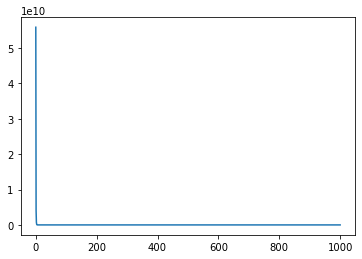

In [29]:
t, E = get_data_from_xvg("minimization_1/energy_1.xvg")
plt.plot(t, E)

Well, that looks funny.

What's happening here is the energy is enormous to start, thanks to unfavorable interactions between the added solvent and ions and the protein, so it drops rapidly thanks to the steepest descent minimization.

To get a better sense for what's going on, let's look at the *change* in energy from step to step, and plot it on the log scale:

In [30]:
def dE(time,energy):
    ''' helper function for getting changes in energy in absolute terms
    '''
    dE = []
    for i in range(len(t)-1):
        dE.append(energy[i+1]-energy[i])
        
    return t[1:], [abs(E) for E in dE] 

Average abs change in energy for the last 50 steps: 107.3825 kJ/mol


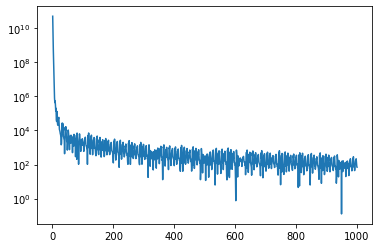

In [31]:
plt.semilogy(dE(t,E)[0], dE(t,E)[1])
print("Average abs change in energy for the last 50 steps: {} kJ/mol".format(np.mean(dE(t,E)[-1][-50:])))

# Equlibration

Now we're going to do some actual Molecular Dynamics simulation.

Take a look at the `equil.mdp` file in the `mdp_files` directory to see the parameters we set for this, but the important bits are:

- `define = -DPOSRES`:  puts restraints on the protein, ligand, and ions (all set to 1000 kJ/(moln m^2))
- `integrator = md`: use the leap-frog numerical integration algorithm
- `nsteps = 500`: do 500 total steps of simulation (500 steps * 0.002 fs/step = 1 ps)
- `dt = 0.002`: each with a time step of 2 fs (base units are ps)
- `nstxout, nstenergy, etc = 5`: sets the number of steps to wait before outputting coordinate and energy (etc.) information in their own respective files (in our case, 5 steps, so output every 10 fs (0.01 ps)

The only new argument to `grompp` here is the `-r` which specfifies the coordinate file to use for the target for restraints. Here's we'll just use the solvated, neutralized crystal structure (`supercell_solvated_neutral.gro`). Make sure this file always has the same number of atoms as the coordiante file. Even if the number of atoms in the actually *restrained* part is the same, if there's a differnt number of solvent atoms, it will complain.

In [32]:
equil_pre = "gmx grompp -f mdp_files/equil.mdp -c minimization_1/min_1.gro -p supercell.top -r supercell_solvated_neutral.gro -o equil_1.tpr -maxwarn 2"
equil_go  = "gmx mdrun -s equil_1.tpr -deffnm equil_1"
subprocess.run([equil_pre], shell=True)
subprocess.run([equil_go], shell=True)

CompletedProcess(args=['gmx mdrun -s equil_1.tpr -deffnm equil_1'], returncode=0)

In [36]:
# move files out of the current directory to keep things clean
clean_up = "mkdir equilibration_1; mv equil_1.* equilibration_1"
subprocess.run([clean_up], shell=True)

CompletedProcess(args=['mkdir equilibration_1; mv equil_1.* equilibration_1'], returncode=0)

We use `gmx energy` again, this time feeding in the selection `19` for the pressure.

In [37]:
get_pressure = "echo 19 | gmx energy -f equilibration_1/equil_1.edr -o equil_pressure_1.xvg"
subprocess.run([get_pressure], shell=True)
subprocess.run(["mv equil_pressure_1.xvg equilibration_1"], shell=True)

CompletedProcess(args=['mv equil_pressure_1.xvg equilibration_1'], returncode=0)

In [38]:
def get_mean_and_std_error(T,P):
    ''' helper funciton for getting the mean and standard error
    '''
    std_error = []
    mean = []
    for i in range(len(T)-1):
        mean.append(np.mean(P[:i+1]))
        std_error.append(np.std(P[:i+1])/np.sqrt(i+1))
    
    return np.array(mean), np.array(std_error)

Final Pressure Estimate: -1275.53 +/- 40.54 bar


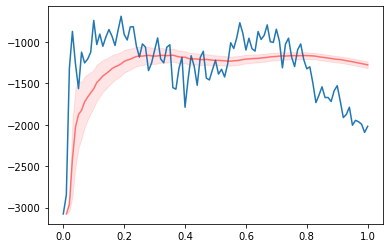

In [39]:
t, p = get_data_from_xvg("equilibration_1/equil_pressure_1.xvg")
mean, std_e = get_mean_and_std_error(t, p)
plt.plot(t,p)
plt.plot(t[1:], mean, color="Red", alpha=0.5)
plt.fill_between(t[1:], mean-std_e, mean+std_e, color="Red", alpha=0.1)
print("Final Pressure Estimate: {:.2f} +/- {:.2f} bar".format(mean[-1], std_e[-1]))

Negative pressure! What does that even mean?

Well it means that there's not enough solvent. There aren't enough solvent molecules at this temperature to fill the space, so the space feels a negative pressure (it would collapse in on itself, if we didn't have periodic boundary conditions).

We need to add more solvent to bring the pressure up.

In normal simulations, we would use the NPT ensemble (constant number of particles, pressure, and temperature), keeping the pressure constant with a barostat by changing the box size (decreasing to increase pressure, increasing to decrease pressure). Here, though, we need to use the NVT ensemble, with constrant volume, becasue we need to keep the crystallographic symmetry by fixing the box size. This means we need to get the pressure up to atmospheric pressure on our own. We accomplish this by adding more waters.

# Adding additional solvent

In [41]:
solvate_cmd = "gmx solvate -cp equilibration_1/equil_1.gro -cs spc216.gro -p supercell.top -o supercell_solvated_neutral_2.gro"
subprocess.run([solvate_cmd], shell=True)

CompletedProcess(args=['gmx solvate -cp equilibration_1/equil_1.gro -cs spc216.gro -p supercell.top -o supercell_solvated_neutral_2.gro'], returncode=0)

In [42]:
min_pre = "gmx grompp -f mdp_files/min.mdp -c supercell_solvated_neutral_2.gro -p supercell.top -o min_2.tpr -maxwarn 2"
min_go = "gmx mdrun -s min_2.tpr -deffnm min_2"
subprocess.run([min_pre], shell=True);
subprocess.run([min_go], shell=True);

In [43]:
clean_up = "mkdir minimization_2; mv min_2.* minimization_2"
subprocess.run([clean_up], shell=True)

CompletedProcess(args=['mkdir minimization_2; mv min_2.* minimization_2'], returncode=0)

In [44]:
get_energy = "echo 11 | gmx energy -f minimization_2/min_2.edr -o energy_2.xvg"
subprocess.run([get_energy], shell=True)
subprocess.run(["mv energy_2.xvg minimization_2"], shell=True)

CompletedProcess(args=['mv energy_2.xvg minimization_2'], returncode=0)

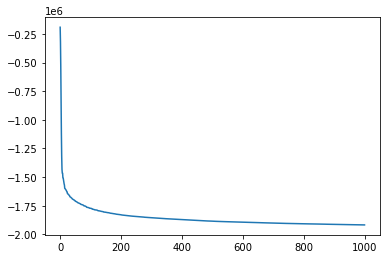

In [45]:
t, E = get_data_from_xvg("minimization_2/energy_2.xvg")
plt.plot(t, E)

Average abs change in energy for the last 50 steps: 61.04 kJ/mol


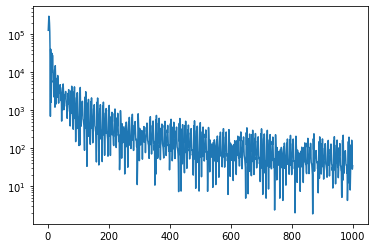

In [46]:
plt.semilogy(dE(t,E)[0], dE(t,E)[1])
print("Average abs change in energy for the last 50 steps: {} kJ/mol".format(np.mean(dE(t,E)[-1][-50:])))

In [47]:
equil_pre = "gmx grompp -f mdp_files/equil.mdp -c minimization_2/min_2.gro -p supercell.top -r supercell_solvated_neutral_2.gro -o equil_2.tpr -maxwarn 2"
equil_go  = "gmx mdrun -s equil_2.tpr -deffnm equil_2"
subprocess.run([equil_pre], shell=True)
subprocess.run([equil_go], shell=True)

CompletedProcess(args=['gmx mdrun -s equil_2.tpr -deffnm equil_2'], returncode=0)

In [48]:
clean_up = "mkdir equilibration_2; mv equil_2.* equilibration_2"
subprocess.run([clean_up], shell=True)

CompletedProcess(args=['mkdir equilibration_2; mv equil_2.* equilibration_2'], returncode=0)

In [49]:
get_pressure = "echo 19 | gmx energy -f equilibration_2/equil_2.edr -o equil_pressure_2.xvg"
subprocess.run([get_pressure], shell=True)
subprocess.run(["mv equil_pressure_2.xvg equilibration_2"], shell=True)

CompletedProcess(args=['mv equil_pressure_2.xvg equilibration_2'], returncode=0)

Final Pressure Estimate: 446.55 +/- 55.15 bar


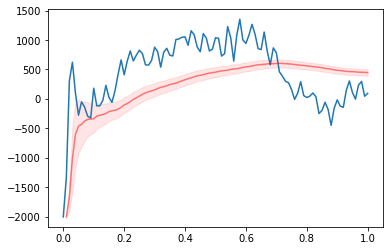

In [50]:
t, p = get_data_from_xvg("equilibration_2/equil_pressure_2.xvg")
mean, std_e = get_mean_and_std_error(t, p)
plt.plot(t,p)
plt.plot(t[1:], mean, color="Red", alpha=0.5)
plt.fill_between(t[1:], mean-std_e, mean+std_e, color="Red", alpha=0.1)
print("Final Pressure Estimate: {:.2f} +/- {:.2f} bar".format(mean[-1], std_e[-1]))

## Now we're close!

In practice, you want longer minimizations (e.g. 5000-10,000 steps) and longer equilibrations (e.g. 10-100 ps) just to make sure everything is stable. But you can get the idea for what we're going even with these short runs.

You basically want to add or remove solvent using the average pressure as a guide.

For instance, our original solvated supercell had 16,531 waters, and the new one has 18,574 (1721 added) and the pressure went from -1275 to 446. We can find an estimate for the number of waters to add to bring us to 1 bar by linear interpolation:

$P = (446-(-1275))/(18574-16531) \mathrm{d}N_{w} + -1275$

where $dN_{w}$ is the change in the number of total waters from the startin number. 

We want to set $P$ to 1 and solve for $N_{w}$ to get an estimate for how many waters to add or subtract in our next run.

$1 = (1721/2043) \mathrm{d}N_{w} - 1275 \rightarrow 1276 = 0.8424 * \mathrm{d}N_{w} \rightarrow \mathrm{d}N_{w} = 1515$

So we added too many: we only needed to add 1515 waters to the original file (if the pressure estiamtes were actually good) but we added 1721.

For the next round, we'd want to eliminate 206 (1721-1515) waters, and run again.

We keep doing this iterative process until the pressure +/- standard error is in the range (-100,100) bar. Then we're ready for production simulation!

# Taking a look at the trajectory

`gmx trjconv` converts the `.trr` trajectory file to another `.trr` trajectory file, but with the molecules mapped back, according to the periodic boundary conditions, so that the molecules are kept whole (`-pbc mol`).

In [67]:
traj_processing = "echo 0 | gmx trjconv -f equilibration_2/equil_2.trr -s equilibration_2/equil_2.tpr -o equil_2_mol.trr -pbc mol"
subprocess.run([traj_processing], shell=True)
subprocess.run(["mv equil_2_mol.trr equilibration_2"], shell=True)

CompletedProcess(args=['mv equil_2_mol.trr equilibration_2'], returncode=0)

In [68]:
import mdtraj as md
traj = md.load("./equilibration_2/equil_2_mol.trr", top="./supercell_solvated_neutral_2.gro")

In [70]:
traj_view = ngl.show_mdtraj(traj)
traj_view.clear_representations()
traj_view.add_cartoon("protein")
traj_view.add_ball_and_stick("water", opacity=0.5)
traj_view.add_spacefill("name CL", color="yellow")
traj_view.add_point("not protein and not water and not name CL")
traj_view.camera = "orthographic"
traj_view

NGLWidget(max_frame=100)